In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import all the required library
import cv2
import os 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import make_blobs
from imutils import paths

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras import backend as K

Using TensorFlow backend.


In [3]:
class SimplePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        # store the target image width, height, and interpolation
        # method used when resizing
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
        # resize the image to a fixed size, ignoring the aspect ratio
        return cv2.resize(image, (self.width, self.height),interpolation=self.inter)

In [4]:
class SimpleDatasetLoader:
    def __init__(self, preprocessors=None):
        #store the image preprocessors
        self.preprocessors = preprocessors

        #if the preprocessors are none initialize as an empty list
        if self.preprocessors is None:
            self.preprocessors = []
            
    def load(self, imagePaths, verbose = -1):
        #initialize the list of fearures nad labels 
        data = []
        labels = []
        
        #loop over the input iamges
        for(i, imagePath) in enumerate(imagePaths):
            image = cv2.imread(imagePath)
            label = imagePath.split(os.path.sep)[-2]
            if self.preprocessors is not None:
                #loop over the preprocessors and apply each to the image
                for p in self.preprocessors:
                    image = p.preprocess(image)
            # treat our processed image as a "feature vector"
            #by updating the data list followed by the labels
            data.append(image)
            labels.append(label)
            
            if verbose > 0 and i >0 and (i+1) % verbose ==0:
                print("[INFO] processed {}/{}".format(i+1, len(imagePaths)))
                
        return (np.array(data), np.array(labels))

In [5]:
# grab the list of images that we’ll be describing
print("[INFO] loading images...")
train_imagePaths = list(paths.list_images("dataset/train/"))
test_imagePaths = list(paths.list_images("dataset/test/"))
validate_imagePaths = list(paths.list_images("dataset/validation/"))

[INFO] loading images...


In [6]:

# initialize the image preprocessor, load the dataset from disk,
# and reshape the data matrix
sp = SimplePreprocessor(32, 32)
sdl = SimpleDatasetLoader(preprocessors=[sp])
lb = LabelBinarizer()

In [7]:
(trainX, trainY) = sdl.load(train_imagePaths, verbose=500)
trainY = lb.fit_transform(trainY)
trainX = trainX.astype("float") / 255.0
trainX.shape

[INFO] processed 500/854


(854, 32, 32, 3)

In [8]:
(validX, validY) = sdl.load(validate_imagePaths, verbose=500)
validY = lb.fit_transform(validY)
validX = validX.astype("float") / 255.0
validX.shape

(282, 32, 32, 3)

In [9]:
(testX, testY) = sdl.load(test_imagePaths, verbose=500)
testY = lb.fit_transform(testY)
testX = testX.astype("float") / 255.0
testX.shape

(292, 32, 32, 3)

In [10]:
class MiniVGGNet:
    @staticmethod
    def build (width, height, depth, classes):
        model=Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
            
        model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        
        model.add(Conv2D(32, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        
        model.add(MaxPooling2D(pool_size =(2,2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(64, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        
        model.add(Conv2D(64, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        
        model.add(MaxPooling2D(pool_size =(2,2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        return model

In [11]:
# initialize the optimizer and model

print("[INFO] compiling model...")
opt = SGD(lr=0.01, decay=0.01 / 40, momentum=0.9, nesterov=True)
model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
print("[INFO] model summary")
model.summary()

[INFO] compiling model...
Instructions for updating:
Colocations handled automatically by placer.
[INFO] model summary
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_

In [12]:
# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(validX, validY),
              batch_size=16, epochs=40, verbose=1)

[INFO] training network...
Instructions for updating:
Use tf.cast instead.
Train on 854 samples, validate on 282 samples
Epoch 1/40
854/854 [==============================] - 19s 22ms/step - loss: 1.8288 - accuracy: 0.5796 - val_loss: 8.7353 - val_accuracy: 0.1702
Epoch 2/40
854/854 [==============================] - 17s 20ms/step - loss: 0.9829 - accuracy: 0.7588 - val_loss: 2.9820 - val_accuracy: 0.4965
Epoch 3/40
854/854 [==============================] - 16s 19ms/step - loss: 0.7770 - accuracy: 0.8056 - val_loss: 3.1469 - val_accuracy: 0.5780
Epoch 4/40
854/854 [==============================] - 17s 20ms/step - loss: 0.7614 - accuracy: 0.8103 - val_loss: 1.0222 - val_accuracy: 0.8085
Epoch 5/40
854/854 [==============================] - 16s 18ms/step - loss: 0.5284 - accuracy: 0.8443 - val_loss: 0.8132 - val_accuracy: 0.8156
Epoch 6/40
854/854 [==============================] - 15s 18ms/step - loss: 0.4796 - accuracy: 0.8712 - val_loss: 0.7603 - val_accuracy: 0.8440
Epoch 7/40
854/

In [13]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=16)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1), 
                            target_names=[str(x) for x in lb.classes_]))


[INFO] evaluating network...
              precision    recall  f1-score   support

    Leopards       1.00      0.97      0.99        40
   airplanes       0.96      0.99      0.98       160
   binocular       0.86      0.75      0.80         8
      cannon       1.00      0.60      0.75        10
 cougar_face       0.69      0.73      0.71        15
 dollar_bill       0.85      1.00      0.92        11
        ewer       0.74      0.82      0.78        17
     gerenuk       0.38      0.38      0.38         8
        ibis       0.73      0.69      0.71        16
   metronome       1.00      0.57      0.73         7

    accuracy                           0.90       292
   macro avg       0.82      0.75      0.77       292
weighted avg       0.91      0.90      0.90       292



plot the training loss and accuracy


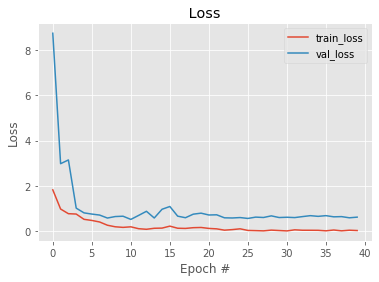

In [15]:
%matplotlib inline
print("plot the training loss and accuracy")
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 40), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), H.history["val_loss"], label="val_loss")
plt.title(" Loss ")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

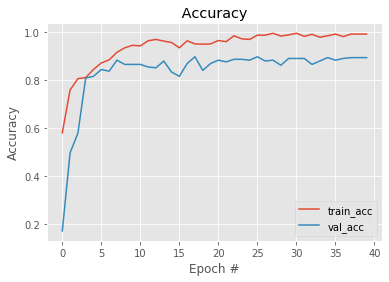

In [17]:
%matplotlib inline
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 40), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 40), H.history["val_accuracy"], label="val_acc")
plt.title(" Accuracy ")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
model.save('model.json')